### [2025.4.13] Simulation of speckle interferometry


1. A rough taget at distance $z$ is illuminated with $M = N\times N$ beams

2. Assume the wavefront of all $M = N\times N$ tilted beams to be flat (plane wave)

3. Tilted beams have Gaussain beam profile with the tilted angle $\phi^{x}_{m}$ in $\hat{x}$ and $\phi^{y}_{n}$ in $\hat{y}$

4. Amplitude reflectivity $\tilde{R}(x,y)$ and randomized phasor $\Gamma$ to simulate $1^{st}$-order speckle patterns

5. Fourier transform the backscattered echos to the receiver pupil plane for $M = N\times N$ beams

6. Calculate the amplitude and phase from the spatial interferometry of $M(M-1)/2$ beams for a given fronzen time

7. Run time evolution


### Challenges and keypoints for the simulation
1. Represent the different incident angles and speckle sizes from an arbtrary unit

2.

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import math
import sys
import time
import os
import h5py
import sympy
import pandas as pd
from datetime import date
from tqdm import tqdm

In [2]:
## the defalt path is ".../code". Need to go to upper directory for parent_dir
os.path.abspath('')
code_dir = "%s/"%os.getcwd()
parent_dir = code_dir.replace('code/','')
function_dir = parent_dir + 'functions/'
data_dir = parent_dir + 'data/'
sys.path.insert(0,parent_dir)

In [3]:
## import coustom functions
import functions.f_complex_phasor_hsl_v1 as chsl
import functions.fbasis_functions_all_v4 as funs_v4
import functions.fbasis_functions_simulation_only_v1 as funs_sim

In [ ]:
## functions
def imag_linear2log_v1(c1,c2,input):
    Ny,Nx = np.shape(input)
    input_mag = np.abs(input)
    in_max = np.max(input_mag)
    out_log = c1*np.log(1+c2*input)/np.log(1+c2*in_max)
    out_log_imag = np.zeros([Ny,Nx])
    out_log_imag[:,:] =out_log
    return out_log_imag 

def showfig_recon_image_spkl_v2(shouldsave,mgx,mgy,D_cir,dimension,irun,Ica,Ics,I_complex_ag_hsl,I_complex_hsl):


    fig,ax = plt.subplots(1,4,figsize=(12,3))
    fig.suptitle(f"Receiver aperture Size = {np.round(D_cir/mgx).astype('int')}x{np.round(D_cir/mgy).astype('int')} specklons")
    ax[0].imshow(Ica,cmap='gray')
    ax[0].set_title("Object (Specular)")
    ax[0].axis('off')
    ax[1].imshow(I_complex_ag_hsl)
    ax[1].set_title("uv-Plane (Specular)")
    ax[1].axis('off')
    ax[2].imshow(Ics,cmap='gray')
    ax[2].set_title("Object (Rough)")
    ax[2].axis('off')
    ax[3].imshow(I_complex_hsl)
    ax[3].set_title("uv-Plane (Specular)")
    ax[3].axis('off')

    if shouldsave:
        save_dir = parent_dir + f"figures/Imag_uv/{dimension}x{dimension}/D_cir{D_cir}pixels/"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_dir + f"Imag_uv_{dimension}x{dimension}_D_cir{D_cir}pixels_run{irun}.pdf", dpi=1000, bbox_inches='tight',transparent=True)


In [5]:
## Load objects
RawI_dir = data_dir + "raw_image/"
# imag1 = plt.imread(RawI_dir+"UCB_Seal_image_v1.png")
imag1 = plt.imread(RawI_dir+"UCB_Seal_image_v2.png")
Ncrop = 3020
Robj1 = imag1[0:Ncrop,0:Ncrop,0]
Ny,Nx = np.shape(Robj1)

In [6]:
##Ideal uv-plane
uv1 = np.fft.fftshift(np.fft.fft2(Robj1))
c1 = 0.9
c2 = 0.01
uv1_log = imag_linear2log_v1(c1,c2,np.abs(uv1))
s0 = 0.9
l0 = 0.9
uv1_log_complex = uv1_log*np.exp(1j*np.angle(uv1))
uv1_hsl = chsl.hsl_complex_v1(s0,l0,uv1_log_complex)

In [ ]:
## save randomized phase
# savepkl = True
# Nrun = int(2**1)

# rand_pkl_dir = data_dir + f"speckle_phase/{Nx}x{Ny}/"
# if savepkl:
#     if not os.path.exists(rand_pkl_dir):
#         os.makedirs(rand_pkl_dir)
# for irun in tqdm(range(Nrun)):
#     gamma_r = np.exp(-1j*2*np.pi*np.random.uniform(low=0.0, high=1.0, size=(Ny,Nx)))
#     pd.DataFrame(gamma_r).to_pickle(rand_pkl_dir + f"speckle_phase_run{irun}.pickle")

100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


In [8]:
## load randomized phase
rand_pkl_dir = data_dir + f"speckle_phase/{Nx}x{Ny}/"

irun = 0
gamma_r = np.array(pd.read_pickle(rand_pkl_dir+f"speckle_phase_run{irun}.pickle"))


In [ ]:
## amplitude distribution
# wx = 0.5*Nx
# wy = 0.5*Ny
mgx = .5
mgy = .5
wx = mgx*Nx
wy = mgy*Ny
x_au = np.linspace(-Nx/2,Nx/2,Nx)
y_au = np.linspace(-Ny/2,Ny/2,Ny)
X_au,Y_au = np.meshgrid(x_au,y_au)
gaus = np.exp(-X_au**2/wx**2 - Y_au**2/wy**2)

In [10]:
ShortFFT = True
p_seg = 1
Bandwidth = 10e6
StartFreq = 70e6
Min_grid = 1e2

if Bandwidth ==10E6:
    bw_str = "10MHz/"
elif Bandwidth == 20E6:
    bw_str = "20MHz/"
else:
    input("Bandwidth is not set to 10 or 20 MHz")

In [11]:
##Sampling rate for the time stamps
SampleFreq = 100e6

In [12]:
##Spatial dimensions and 2D grid
va = 600
Dfringes = 1/4.5e-3
Mag = Bandwidth/va/Dfringes
Factor_NySampling = 2
lbda = .5e-6
Dist = 1e2
Rx_Diameter = 25e-3

In [ ]:
#Dimension setting: dimension choices: 2, 4, 5, 6, 8, 12, 16, 24, 32, 48
dimension_case = 2
if dimension_case == 1:
    dimension_all = np.array([16]).astype('int')
elif dimension_case == 2:
    dimension_all = np.array([24]).astype('int')

In [14]:
Phase_tone_case = 2

In [15]:
m_k = 0.1     ## scaled factor of the angle/k-vector
# m_k = 1     ## scaled factor of the angle/k-vector

In [16]:
## Receiver aperture
D_cir = 2500
W_cir = np.zeros([Ny,Nx])
W_cir[X_au**2+Y_au**2<(D_cir/2)**2] = 1

angles = np.linspace(0,np.pi*4,400)
x_rx = np.sin(angles)*D_cir/2+Nx/2
y_rx = np.cos(angles)*D_cir/2+Ny/2

In [ ]:
for dimension_ind,dimension in enumerate(dimension_all):
    if Phase_tone_case ==1:
        ##Case1: Zero phases
        Phase_signal = np.zeros((dimension,1))
        Phase_signal_x = Phase_signal
        Phase_signal_y = Phase_signal
        Phase_name = "ZeroPhases"
    elif Phase_tone_case==2:
        ##Case2: Random phases
        Name_Rx = f"{data_dir+'Phase_offset/'}Rand_phase_x_{dimension:.0f}Signals.mat"
        Name_Rx_hfile = h5py.File(Name_Rx, 'r')
        Phase_signal_x_h5 = Name_Rx_hfile.get("Phase_signal_x")
        Phase_signal_x = np.array(Phase_signal_x_h5)
        Name_Ry = f"{data_dir+'Phase_offset/'}Rand_phase_y_{dimension:.0f}Signals.mat"    
        Name_Ry_hfile = h5py.File(Name_Ry, 'r')
        Phase_signal_y_h5 = Name_Ry_hfile.get("Phase_signal_y")
        Phase_signal_y = np.array(Phase_signal_y_h5)
        Phase_name = "RandomPhases"    
    elif Phase_tone_case==3:    
        ## Case3: Quantized phases over 2*pi [rad]
        Phase_signal = np.linspace(0, 2*math.pi - 2*math.pi/dimension, dimension)
        Phase_signal_x = Phase_signal
        Phase_signal_y = Phase_signal
        Phase_name = "QuantizedPhases"  

    ##Part 1: 1D NRA dataset (dimension 2, 4, 5, 6, 8, 12, 16, 24, 32, 48)
    nra_1d = funs_v4.fbasis_nra_1d_gen_v1(dimension)

    ##Part 2: 2D NRA generator RF beatnotes
    LR1Ds,gridsize, p_list, p_ix, prime_num, prime_denom, yxratio = funs_v4.fbasis_2dNRA_gen_v1(dimension, nra_1d)

    ##Part 3: Set Y/X scale factor to ratio of two primes nearest to twice the RF grid size
    nra_x,nra_y,LR2Ds,LR2Ds_beat,LR2Ds_beat_reshaped,LR2Ds_beat_sorted,Ind_sort = funs_v4.fbasis_2dNRA_LR2Ds_beat_v1(nra_1d,yxratio)

    ##Part 4: 2D frequency array setting
    Factor_mod,SignalFreq_array_x,SignalFreq_array_y,BeatFreq_1d,BeatFreq_array,IA,IC,LR2Ds_beat_1d,LR2Ds_beat_1d_unique = funs_v4.fbasis_2d_beatnote_v1(Bandwidth,StartFreq,nra_x,nra_y,LR2Ds_beat)

    ##Part 5: Offset Phase Array for 2D NRA
    Phase_2Ds,Phase_1Ds_beat,Phase_1Ds_beat_sorted,diff_beat_min,N_period = funs_v4.fbasis_phase_beat_v1(nra_1d,nra_x,nra_y,Phase_signal_x,Phase_signal_y,Ind_sort,IA,SampleFreq,BeatFreq_array)

    ##Part 6: Spatial fringes and 2D grids
    _,_,Ngrid_x,Ngrid_y,delta_x,delta_y,_,_ = funs_v4.fbasis_set2dgrid_dim_v1(BeatFreq_array,SignalFreq_array_x,SignalFreq_array_y,Factor_NySampling,va)

    ##Part 7: Set the 2D spatial grids pass zero x and y, with even number of grids for convenience.
    _,_,_,_,_,_,_,_,_,_,_,_,Nx_AO,Ny_AO = funs_v4.fbasis_2dgrid_gen_v1(Ngrid_x,Ngrid_y,delta_x,delta_y,Mag,lbda,Dist)

    ## 2D plane waves for M = N x N beams
    nra_x_norm = 2*(nra_x - nra_x[-1]/2)/nra_x[-1]
    nra_y_norm = 2*(nra_y - nra_y[-1]/2)/nra_y[-1]*yxratio

    spl_obj_4d = np.zeros((Ny,Nx,len(nra_y),len(nra_x)),dtype='complex64')
    spl_obj_4d_ag = np.zeros((Ny,Nx,len(nra_y),len(nra_x)),dtype='complex64')

    for itonex in tqdm(range(len(nra_x_norm))):
        for itoney in range(len(nra_x_norm)):
            pw = np.exp(-1j*2*np.pi*m_k*(nra_x_norm[itonex]*X_au + nra_y_norm[itoney]*Y_au))
            ## speckle with object reflectivity
            spl_obj = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gaus*Robj1*pw*gamma_r)))
            spl_obj_ag = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gaus*Robj1*pw)))
            spl_obj_4d[:,:,itoney,itonex] = spl_obj
            spl_obj_4d_ag[:,:,itoney,itonex] = spl_obj_ag

    ## Multibeam speckle interferometry
    uv_cover = np.zeros((Ny_AO,Nx_AO))
    I_complex = np.zeros((Ny_AO,Nx_AO),dtype='complex64')
    I_complex_ag = np.zeros((Ny_AO,Nx_AO),dtype='complex64')

    for itonex1 in (range(len(nra_x_norm))):
        for itonex2 in tqdm(range(len(nra_x_norm))):
            for itoney1 in (range(len(nra_y_norm))):
                for itoney2 in (range(len(nra_y_norm))):
                    uvx = nra_x_norm[itonex1] - nra_x_norm[itonex2]
                    uvy = nra_y_norm[itoney1] - nra_y_norm[itoney2]
                    indx = np.round((uvx+2*nra_x_norm[-1])/np.min(np.diff(nra_x_norm))).astype('int')
                    indy = np.round((uvy+2*nra_y_norm[-1])/np.min(np.diff(nra_y_norm))).astype('int')
                    uv_cover[indy,indx] = 1
                    I_complex[indy,indx] = np.sum(spl_obj_4d[:,:,itoney1,itonex1]*np.conjugate(spl_obj_4d[:,:,itoney2,itonex2])*W_cir)
                    I_complex_ag[indy,indx] = np.sum(spl_obj_4d_ag[:,:,itoney1,itonex1]*np.conjugate(spl_obj_4d_ag[:,:,itoney2,itonex2])*W_cir)

    Ics = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(I_complex))))
    Ica = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(I_complex_ag))))
    Icsa = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(I_complex_ag)))) - np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(I_complex))))

    c1 = 1
    c2 = 0.0000001
    I_complex_ag_log = imag_linear2log_v1(c1,c2,np.abs(I_complex_ag))
    I_complex_log = imag_linear2log_v1(c1,c2,np.abs(I_complex))
    I_complex_ag_hsl = chsl.hsl_complex_v1(s0,l0,I_complex_ag_log*np.exp(1j*np.angle(I_complex_ag)))
    I_complex_hsl = chsl.hsl_complex_v1(s0,l0,I_complex_log*np.exp(1j*np.angle(I_complex)))

    ## save the reconstructed images
    Ics_dir = data_dir + f"Recon_image/Ics/{dimension:.0f}x{dimension:.0f}/D_cir{D_cir}pixels/"
    Ica_dir = data_dir + f"Recon_image/Ica/{dimension:.0f}x{dimension:.0f}/D_cir{D_cir}pixels/"

    saveimgpkl = True
    if saveimgpkl:
        if not os.path.exists(Ics_dir):
            os.makedirs(Ics_dir)
        if not os.path.exists(Ica_dir):
            os.makedirs(Ica_dir)
        pd.DataFrame(Ics).to_pickle(Ics_dir + f"Ics_{Nx_AO}x{Nx_AO}pixels_run{irun}.pickle")
        pd.DataFrame(Ica).to_pickle(Ica_dir + f"Ica_{Nx_AO}x{Nx_AO}pixels_run{irun}.pickle")

    ## save the 2D speckle image
    shoudlsave = True
    # showfig_recon_image_spkl_v1(shoudlsave,mgx,mgy,D_cir,dimension,irun,Ica,Ics,Icsa)
    showfig_recon_image_spkl_v2(shoudlsave,mgx,mgy,D_cir,dimension,irun,Ica,Ics,I_complex_ag_hsl,I_complex_hsl)

100%|██████████| 16/16 [04:04<00:00, 15.31s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/IMPEL_encrypted/Simulation/Python_simulation/spkl_inteferometry/data/speckle_4D/16x16/Beamwidth_1510x1510/speckle_4D_run0.pickle'

In [ ]:
## Multibeam speckle interferometry
uv_cover = np.zeros((Ny_AO,Nx_AO))
I_complex = np.zeros((Ny_AO,Nx_AO),dtype='complex64')
I_complex_ag = np.zeros((Ny_AO,Nx_AO),dtype='complex64')

for itonex1 in tqdm(range(len(nra_x_norm))):
    for itonex2 in range(len(nra_x_norm)):
        for itoney1 in range(len(nra_y_norm)):
            for itoney2 in range(len(nra_y_norm)):
                uvx = nra_x_norm[itonex1] - nra_x_norm[itonex2]
                uvy = nra_y_norm[itoney1] - nra_y_norm[itoney2]
                indx = np.round((uvx+2*nra_x_norm[-1])/np.min(np.diff(nra_x_norm))).astype('int')
                indy = np.round((uvy+2*nra_y_norm[-1])/np.min(np.diff(nra_y_norm))).astype('int')
                uv_cover[indy,indx] = 1
                # I_complex[indy,indx] = np.sum(spl_obj_4d[:,:,itoney1,itonex1]*np.conjugate(spl_obj_4d[:,:,itoney2,itonex2]) + np.conjugate(spl_obj_4d[:,:,itoney1,itonex1])*spl_obj_4d[:,:,itoney2,itonex2])
                I_complex[indy,indx] = np.sum(spl_obj_4d[:,:,itoney1,itonex1]*np.conjugate(spl_obj_4d[:,:,itoney2,itonex2])*W_cir)
                I_complex_ag[indy,indx] = np.sum(spl_obj_4d_ag[:,:,itoney1,itonex1]*np.conjugate(spl_obj_4d_ag[:,:,itoney2,itonex2])*W_cir)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# uv_cover = np.zeros((Ny_AO,Nx_AO))
# I_complex = np.zeros((Ny_AO,Nx_AO),dtype='complex64')
# I_complex_ag = np.zeros((Ny_AO,Nx_AO),dtype='complex64')

# for itonex1 in tqdm(range(len(nra_x_norm))):
#     for itonex2 in range(len(nra_x_norm)):
#         for itoney1 in range(len(nra_y_norm)):
#             for itoney2 in range(len(nra_y_norm)):
#                 uvx = nra_x_norm[itonex1] - nra_x_norm[itonex2]
#                 uvy = nra_y_norm[itoney1] - nra_y_norm[itoney2]
#                 indx = np.round((uvx+2*nra_x_norm[-1])/np.min(np.diff(nra_x_norm))).astype('int')
#                 indy = np.round((uvy+2*nra_y_norm[-1])/np.min(np.diff(nra_y_norm))).astype('int')
#                 uv_cover[indy,indx] = 1
#                 # I_complex[indy,indx] = np.sum(spl_obj_4d[:,:,itoney1,itonex1]*np.conjugate(spl_obj_4d[:,:,itoney2,itonex2]) + np.conjugate(spl_obj_4d[:,:,itoney1,itonex1])*spl_obj_4d[:,:,itoney2,itonex2])
#                 I_complex[indy,indx] = np.sum(spl_obj_4d[:,:,itoney1,itonex1]*np.conjugate(spl_obj_4d[:,:,itoney2,itonex2])*W_cir)
#                 I_complex_ag[indy,indx] = np.sum(spl_obj_4d_ag[:,:,itoney1,itonex1]*np.conjugate(spl_obj_4d_ag[:,:,itoney2,itonex2])*W_cir)

100%|██████████| 16/16 [03:25<00:00, 12.87s/it]


Text(0.5, 1.0, 'uv-plane coverage')

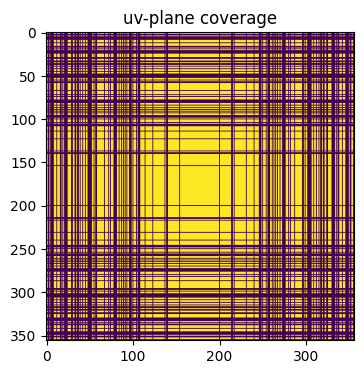

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(uv_cover)
ax.set_title("uv-plane coverage")

In [ ]:
pw_sum = np.zeros((Ny,Nx),dtype='complex64')

for itonex in (range(len(nra_x_norm))):
    for itoney in (range(len(nra_y_norm))):
        pw = np.exp(-1j*2*np.pi*m_k*(nra_x_norm[itonex]*X_au + nra_y_norm[itoney]*Y_au))
        pw_sum = pw_sum + pw
# pw = np.exp(-1j*2*np.pi*m_k*(nra_x_norm[5]*X_au + nra_y_norm[5]*Y_au))
spl_obj_ag = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gaus*Robj1*pw_sum)))
spl_obj_bm = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gaus*pw_sum)))
spl_obj = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gaus*Robj1*pw_sum*gamma_r)))

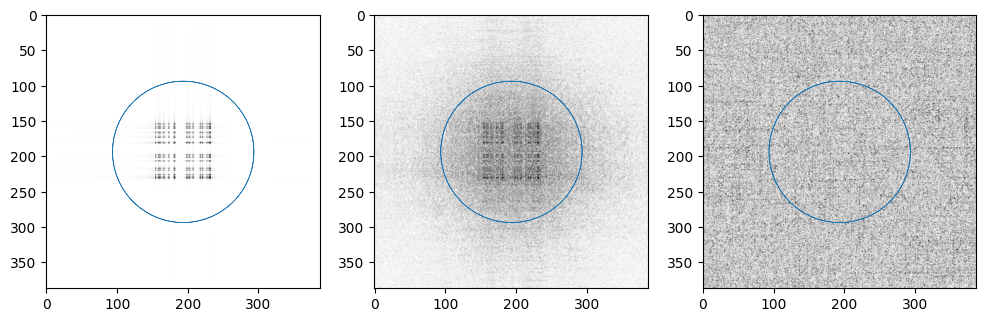

In [ ]:
c1 = 1
c2 = 0.001
spl_obj_ag_log = imag_linear2log_v1(c1,c2,np.abs(spl_obj_ag))
c1 = 1
c2 = 0.0001
spl_obj_ag_bm_log = imag_linear2log_v1(c1,c2,np.abs(spl_obj_bm))

fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(np.abs(spl_obj_ag_bm_log),cmap='binary')
ax[0].plot(x_rx,y_rx,'C0',linewidth=0.5)
ax[1].imshow(np.abs(spl_obj_ag_log),cmap='binary')
ax[1].plot(x_rx,y_rx,'C0',linewidth=0.5)
ax[2].imshow(np.abs(spl_obj),cmap='binary')
ax[2].plot(x_rx,y_rx,'C0',linewidth=0.5)
# plt.colorbar()
fig_dir = parent_dir + 'figures/'
plt.savefig(fig_dir + f"temp/beam_pipil_v1.pdf", dpi=1000, bbox_inches='tight')
plt.show()

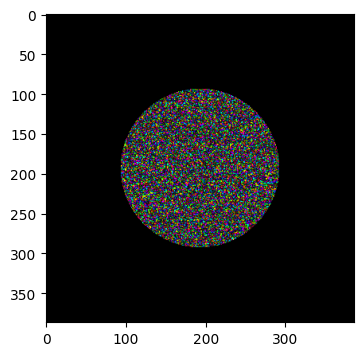

In [ ]:
pw = np.exp(-1j*2*np.pi*m_k*(nra_x_norm[10]*X_au+nra_y_norm[0]*Y_au))

# D_cir = 100
# W_cir = np.zeros([Ny,Nx])
# W_cir[X_au**2+Y_au**2<(D_cir/2)**2] = 1

## speckle with object reflectivity
spl_obj = (np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gaus*Robj1*pw*gamma_r))))*W_cir
spl_obj_hsl = chsl.hsl_complex_v1(s0,l0,spl_obj)

fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(spl_obj_hsl)

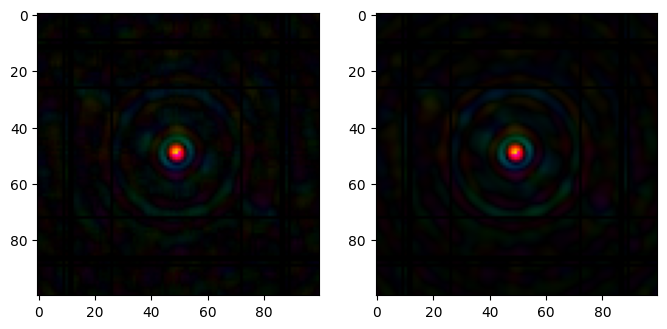

In [ ]:
I_complex_hsl = chsl.hsl_complex_v1(s0,l0,I_complex)
I_complex_ag_hsl = chsl.hsl_complex_v1(s0,l0,I_complex_ag)
dx = 50
dy = 50
(x1,x2,y1,y2) = (int(Nx_AO/2)-dx,int(Nx_AO/2)+dx,int(Ny_AO/2)-dy,int(Ny_AO/2)+dy)
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(I_complex_hsl[y1:y2,x1:x2],cmap='gray')
ax[1].imshow(I_complex_ag_hsl[y1:y2,x1:x2],cmap='gray')

In [ ]:
# plt.imshow(np.real(I_complex-I_complex_ag),cmap='bwr')

Text(0.5, 1.0, 'Difference')

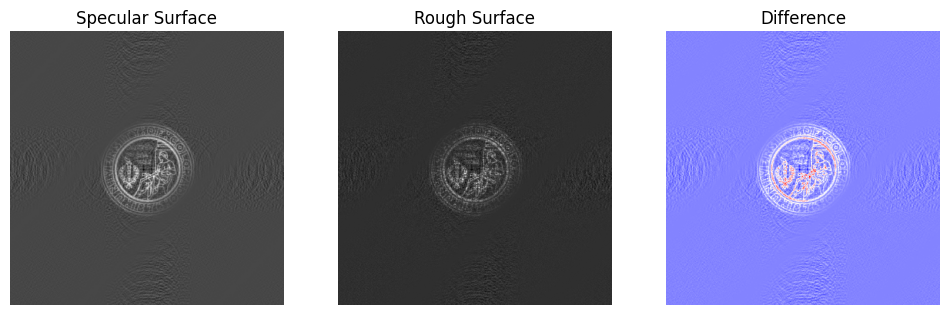

In [ ]:
dx = 400
dy = 400
(x1,x2,y1,y2) = (int(Nx_AO/2)-dx,int(Nx_AO/2)+dx,int(Ny_AO/2)-dy,int(Ny_AO/2)+dy)
Ics = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(I_complex))))
Ica = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(I_complex_ag))))
Icsa = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(I_complex_ag)))) - np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(I_complex))))

fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(Ica,cmap='gray')
ax[0].set_title("Specular Surface")
ax[0].axis('off')
ax[1].imshow(Ics,cmap='gray')
ax[1].set_title("Rough Surface")
ax[1].axis('off')
ax[2].imshow(Icsa,cmap='bwr')
ax[2].axis('off')
ax[2].set_title("Difference")


In [ ]:
print(np.max(Ics))
print(np.max(Ica))

245770.97
659238.4


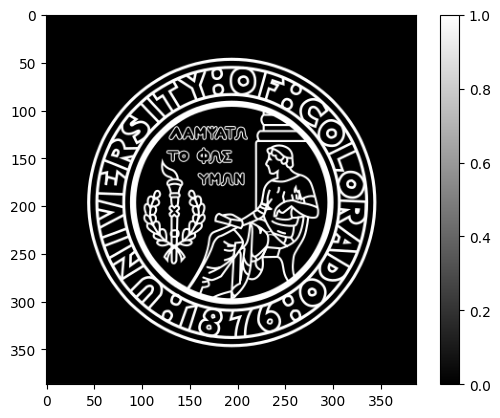

In [ ]:
## Object
dx = 160
dy = 160
(x1,x2,y1,y2) = (int(Nx/2)-dx,int(Nx/2)+dx,int(Ny/2)-dy,int(Ny/2)+dy)
# plt.imshow(Robj1[y1:y2,x1:x2], cmap='gray')
plt.imshow(Robj1, cmap='gray')
# plt.axis('off')
plt.colorbar()